Testing Empirical cumulative distribution in 2-D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import pandas as pd
import datetime
import warnings


def loadData(files, days=365):
    
    dataFrames_in = []
    start_dates = []
    end_dates =[]
    
    for file in files:
        df_in = pd.read_csv('C:/Users/worc3920/Documents/GitHub/EmpiricalPortfolio/'+file+'.csv', usecols=["Date","Close"])
        df_in = df_in.rename(columns={"Close": "Close_" + file})
        df_in["Date"]=pd.to_datetime(df_in["Date"], infer_datetime_format=True)
        dataFrames_in.append(df_in)
        start_dates.append(df_in.loc[0,"Date"])
        end_dates.append(df_in.loc[df_in.index[-1],"Date"])
    
    df_start = max(start_dates)
    df_end = min(end_dates)
    df = pd.DataFrame()
    df["Date"] = pd.date_range(start=df_start, end=df_end)
    
    for i in range(len(files)):
        df = df.merge(dataFrames_in[i], on='Date', how='left')

    for file in files:
        for i in range(1,len(df)):    
            if np.isnan(df.loc[i,"Close_" + file]):
                df.loc[i, "Close_" + file] = df.loc[i-1, "Close_"+file]
        for i in range(len(df)-days):
            df.loc[i, "Return_" + file] = df.loc[i+days, "Close_"+file]/df.loc[i, "Close_"+file]-1
    #drop last days intries
    return df.drop(columns=["Close_" + file for file in files]).iloc[:-days]

files = ["gspc","gold"]
df = loadData(files)
df.describe()

,Return_gspc,Return_gold
count,18923.000000,18923.000000
mean,0.082139,0.104385
std,0.161644,0.275879
min,-0.488228,-0.422125
25%,-0.008728,-0.064313
50%,0.099072,0.050388
75%,0.187215,0.216055
max,0.685734,2.695652


In [2]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

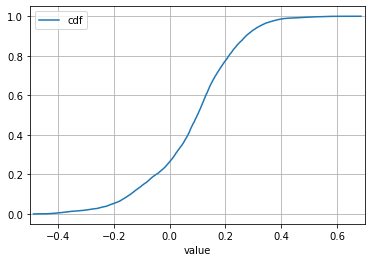

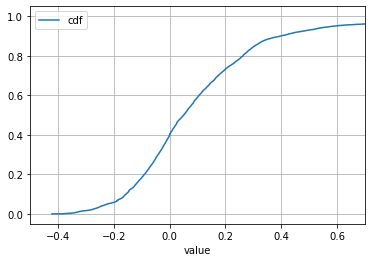

In [3]:
def getEmpiricalDensity(series):
    df2=pd.DataFrame()
    df2["value"]=series
    # Frequency
    stats_df = df2 \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    
    # Plot
    #stats_df.plot(x = 'value', y = 'pdf', grid = True)
    ax = stats_df.plot(x = 'value', y = 'cdf', xlim=(-0.5,0.7), grid = True)

for file in files:
    getEmpiricalDensity(df["Return_" + file])

,Return_gspc,Return_gold
Return_gspc,1.000000,-0.101647
Return_gold,-0.101647,1.000000


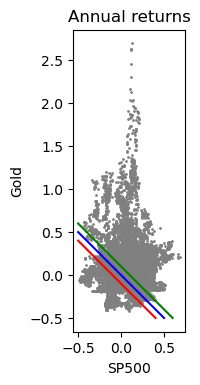

In [4]:
x1 = df["Return_gspc"].to_numpy()
x2 = df["Return_gold"].to_numpy()

fig=plt.figure(figsize = (6,4), dpi = 100)

ax1 = plt.scatter(x1,x2,s=1,c='grey')
ax1 = plt.xlabel('SP500')
ax1 = plt.ylabel('Gold')
ax1 = plt.title('Annual returns')

ax1 = plt.plot([-0.5,0.5],[0.5,-0.5],'b')
ax1 = plt.plot([-0.5,0.4],[0.4,-0.5],'r')
ax1 = plt.plot([-0.5,0.6],[0.6,-0.5],'g')
plt.gca().set_aspect('equal', adjustable='box')

df.corr()

In [5]:
#Let's build a MILP
from mip import *

def myopt(x1,x2,alpha, VaR=0, boundary = 10**6, d=2, max_s = 5):
    n=len(x1)
    mean_x1=np.mean(x1)
    mean_x2=np.mean(x2)
    
    n_activeCon = np.ceil(n*alpha) #number of active constraints

    m = Model(solver_name=CBC)
    w = [ m.add_var(var_type=CONTINUOUS) for dd in range(d) ] #asset weights
    z = [ m.add_var(var_type=BINARY) for nn in range(n) ] #deactivation switches


    #objective
    m.objective = minimize(-(w[0]*mean_x1+w[1]*mean_x2))

    #constaints
    m += xsum(w[dd] for dd in range(d)) == 1
    m += xsum(z[nn] for nn in range(n)) == n_activeCon

    for nn in range(n):
        m += w[0]*x1[nn]+w[1]*x2[nn] >= (VaR - (1-z[nn])*boundary) #VaR constraint
    
    #obtain model summary
    #m.write('model.lp')
    #m.read('model.lp')
    #print('model has {} vars, {} constraints and {} nzs'.format(m.num_cols, m.num_rows, m.num_nz))

    # optimizing
    status = m.optimize(max_seconds = max_s)
    if status != OptimizationStatus.OPTIMAL:
        print(np.round(alpha,3), np.round(VaR,3), status)
    return m

#ax2=plt.plot(alphas,w0Star)
#ax2=plt.plot(alphas,1-w0Star,'r')

In [6]:
n=len(df)
n_a = 3
n_v = 3

mean_x1=x1.mean()
mean_x2=x2.mean()
alphas=np.linspace(0.3,0.6,n_a)
VaRs=np.linspace(-0.3,-0.1,n_v)
w0Star=np.zeros((n_a,n_v))

pars = [(i, j) for i in range(n_a) for j in range(n_v)]
for i,j in pars:
    w0Star[i,j] = myopt(x1,x2/1.25,alphas[i],VaR=VaRs[j], max_s=1).vars[0].x


In [7]:
w0Star
print(mean_x1, mean_x2)
print(np.std(x1),np.std(x2))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [14]:
m=myopt(x1,x2,0.1,VaR=-1)

In [15]:
d=2
switched_off=[]
switched_on=[]
for i in range(n):
    if m.vars[i+d].x == 1:
        switched_off.append(i)
    else:
        switched_on.append(i)

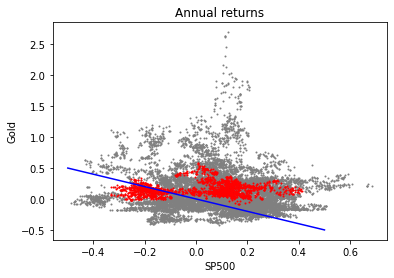

In [16]:
ax1 = plt.scatter(x1[switched_on],x2[switched_on],s=1,c='grey')
ax1 = plt.scatter(x1[switched_off],x2[switched_off],s=1,c='red')
ax1 = plt.xlabel('SP500')
ax1 = plt.ylabel('Gold')
ax1 = plt.title('Annual returns')

ax1 = plt.plot([-0.5,0.5],[0.5,-0.5],'b')

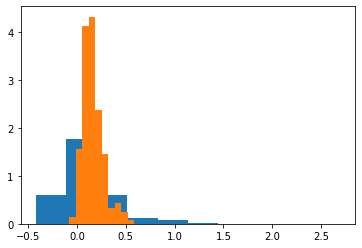

In [20]:
ax2 = plt.hist(m.vars[0].x*x1[switched_on]+m.vars[1].x*x2[switched_on], density=True)
ax2 = plt.hist(m.vars[0].x*x1[switched_off]+m.vars[1].x*x2[switched_off], density=True)